```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Python 2.7 compatibility
from __future__ import print_function

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import mpld3

import subprocess
import os
import gc
import datetime

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Finally, import our simulator
from SWESimulators import Common, LxF, FORCE, HLL, HLL2, KP07, KP07_dimsplit, WAF, PlotHelper

In [2]:
import atexit
def exitfunc():
    #Clean up old context if any:
    if 'cuda_context' in globals():
        print("Deleting existing context")
        global cuda_context
        del cuda_context
        gc.collect()
    else:
        print("No existing CUDA context")
        gc.collect()
        
atexit.register(exitfunc)
exitfunc()
    
cuda_context = Common.CudaContext(verbose=True, blocking=False)

No existing CUDA context
CUDA version (9, 1, 0)
Driver version 9010
Using GeForce 840M
 => compute capability: (5, 0)
 => memory: 2048.0 MB
Created context <282413553776>


In [3]:
#Misc plotting setup
def setBwStyles(ax):
    from cycler import cycler

    ax.set_prop_cycle( cycler('marker', ['.', 'x', 4, '+', '*', '1', 5]) +
                       cycler('linestyle', ['-.', '--', ':', '-.', '--', ':', '-.']) +
                       #cycler('markersize', [5, 5, 5, 5, 5, 5]) +
                       cycler('color', ['k', 'k', 'k', 'k', 'k', 'k', 'k']) )    

#Set large figure sizes
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'
#plt.rcParams['legend.markerscale'] = 1.0
#plt.rcParams['lines.markersize'] = 6
plt.rcParams['lines.markeredgewidth'] = 1.5
#plt.rcParams['savefig.dpi'] = 400

In [4]:
def save_figure(fig, stem):
    fig_filename = "convergence_smooth1d_" + stem + ".pdf"
    
    image_text = fig_filename + "\nCreated " + str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
    #ax = fig.gca()
    #pos1 = ax.get_position() # get the original position 
    #pos2 = [pos1.x0 + 0.3, pos1.y0 + 0.3,  pos1.width / 2.0, pos1.height / 2.0] 
    #ax.set_position(pos2) # set a new position
    
    #fig.gca().annotate(image_text, xy=(1.1, 0), xycoords='figure fraction', fontsize=10,
    #                   horizontalalignment='right', verticalalignment='bottom')
    t = plt.figtext(-0.1, .9, image_text, rotation='vertical')
    
    legend = fig.gca().legend_
    if (legend != None):
        fig.savefig(fig_filename, bbox_extra_artists=(legend,t, ), bbox_inches='tight')
    else:
        fig.savefig(fig_filename)

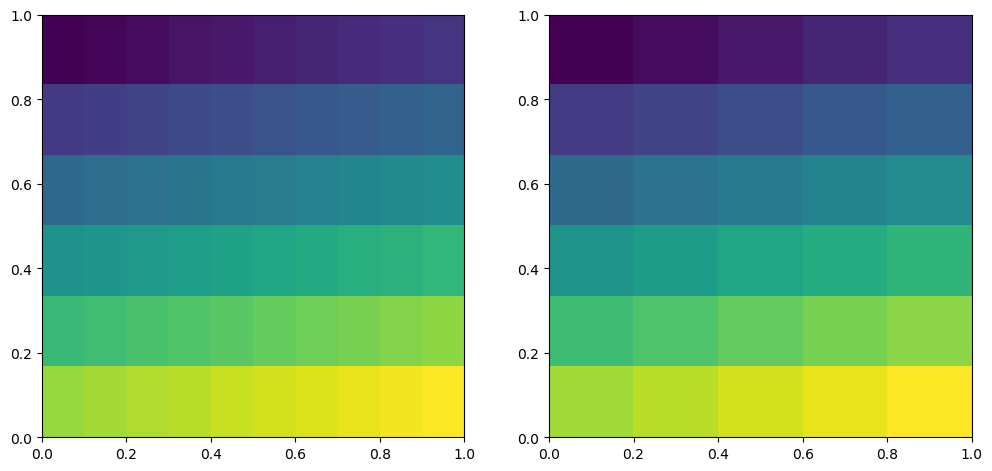

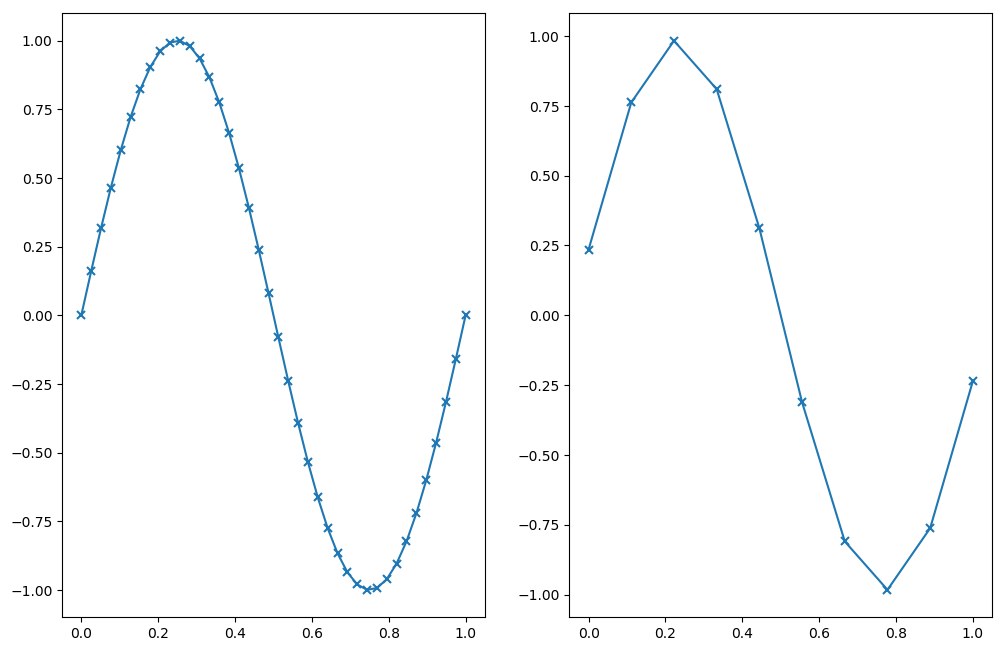

In [5]:
def downsample(highres_solution, factor):
    if (len(highres_solution.shape) == 1):
        highres_solution = highres_solution.reshape((1, highres_solution.size))

    assert(highres_solution.shape[1] % factor == 0)
    ny = highres_solution.shape[0] 
    nx = highres_solution.shape[1] / factor

    if (factor == 1):
        return highres_solution
    else:
        
        return highres_solution.reshape([int(ny), int(1), int(nx), int(factor)]).mean(3).mean(1)
    

# Test 2D downsample
a = np.arange(60).reshape((6, 10))
b = downsample(a, 2)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(a, extent=[0, 1, 0, 1])

plt.subplot(1,2,2)
plt.imshow(b, extent=[0, 1, 0, 1])
plt.show()

# Test 1D downsample
a = np.sin(np.linspace(0, 2*np.pi, 40))
b = downsample(a, 4)

plt.figure()
plt.subplot(1,2,1)
plt.plot(np.linspace(0, 1, a.size), a.flatten(), 'x-')

plt.subplot(1,2,2)
plt.plot(np.linspace(0, 1, b.size), b.flatten(), 'x-')
plt.show()

In [6]:
def wall_boundary_conditions(data, num_ghost_cells):
    data[0:num_ghost_cells,:] = data[2*num_ghost_cells-1:num_ghost_cells-1:-1,:]
    data[-num_ghost_cells:,:] = data[-num_ghost_cells-1:-2*num_ghost_cells-1:-1,:]
    data[:,0:num_ghost_cells] = data[:,2*num_ghost_cells-1:num_ghost_cells-1:-1]
    data[:,-num_ghost_cells:] = data[:,-num_ghost_cells-1:-2*num_ghost_cells-1:-1]
    return data

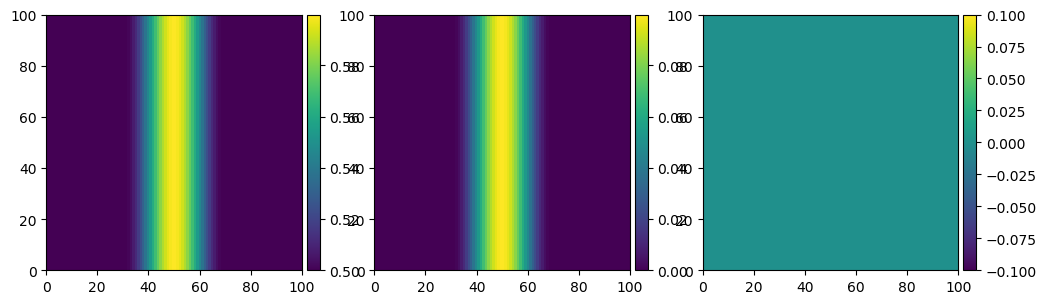

[1.0, 50.0, 0.27710612593755635]


In [7]:
def gen_test_data(nx, ref_nx, g, num_ghost_cells):
    assert(num_ghost_cells >= 1)
    ref_ny = num_ghost_cells
    ny = ref_ny
    
    width = 100.0
    height = 100.0
    ref_dx = width / float(ref_nx)
    ref_dy = height / float(ref_ny)

    x_center = ref_dx*ref_nx/2.0
    y_center = ref_dy*ref_ny/2.0

    #Create a gaussian "dam break" that will not form shocks
    size = width / 5.0
    dt = 10**10
    
    h  = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32); 
    hu = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    hv = np.zeros((ny+2*num_ghost_cells, nx+2*num_ghost_cells), dtype=np.float32);
    
    x = ref_dx*(np.arange(0, ref_nx, dtype=np.float32)+0.5) - x_center
    y = ref_dy*(np.arange(0, ref_ny, dtype=np.float32)+0.5) - y_center
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    r = np.sqrt(xv**2)
    xv = None
    yv = None
    gc.collect()
    
    #Make sure that the wanted resolution is suitable
    assert(ref_nx >= nx)
    assert(ref_ny >= ny)
    
    #Generate highres then downsample
    #h_highres = 0.5 + 0.1*np.exp(-(xv**2/size + yv**2/size))
    h_highres = 0.5 + 0.1*0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    h[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells] = downsample(h_highres, ref_nx/nx)
    h_highres = None
    gc.collect()
    
    #hu_highres = 0.1*np.exp(-(xv**2/size + yv**2/size))
    hu_highres = 0.1*0.5*(1.0 + np.cos(np.pi*r/size)) * (r < size)
    hu[num_ghost_cells:-num_ghost_cells, num_ghost_cells:-num_ghost_cells] = downsample(hu_highres, ref_nx/nx)
    hu_highres = None
    gc.collect()
    
    #Fix boundary conditions
    h = wall_boundary_conditions(h, num_ghost_cells);
    hu = wall_boundary_conditions(hu, num_ghost_cells);
    
    scale = 0.7
    max_h_estimate = 0.6
    max_u_estimate = 0.1
    dx = width/nx
    dy = height/ny
    dt = scale * min(dx, dy) / (max_u_estimate + np.sqrt(g*max_h_estimate))
    
    return h, hu, hv, dx, dy, dt

h, hu, hv, dx, dy, dt = gen_test_data(nx=100, ref_nx=1000, g=9.81, num_ghost_cells=2)

plt.figure()
ax=plt.subplot(1,3,1)
im=plt.imshow(h, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,2)
im=plt.imshow(hu, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ax=plt.subplot(1,3,3)
im=plt.imshow(hv, extent=[0, 100, 0, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()

print([dx, dy, dt])

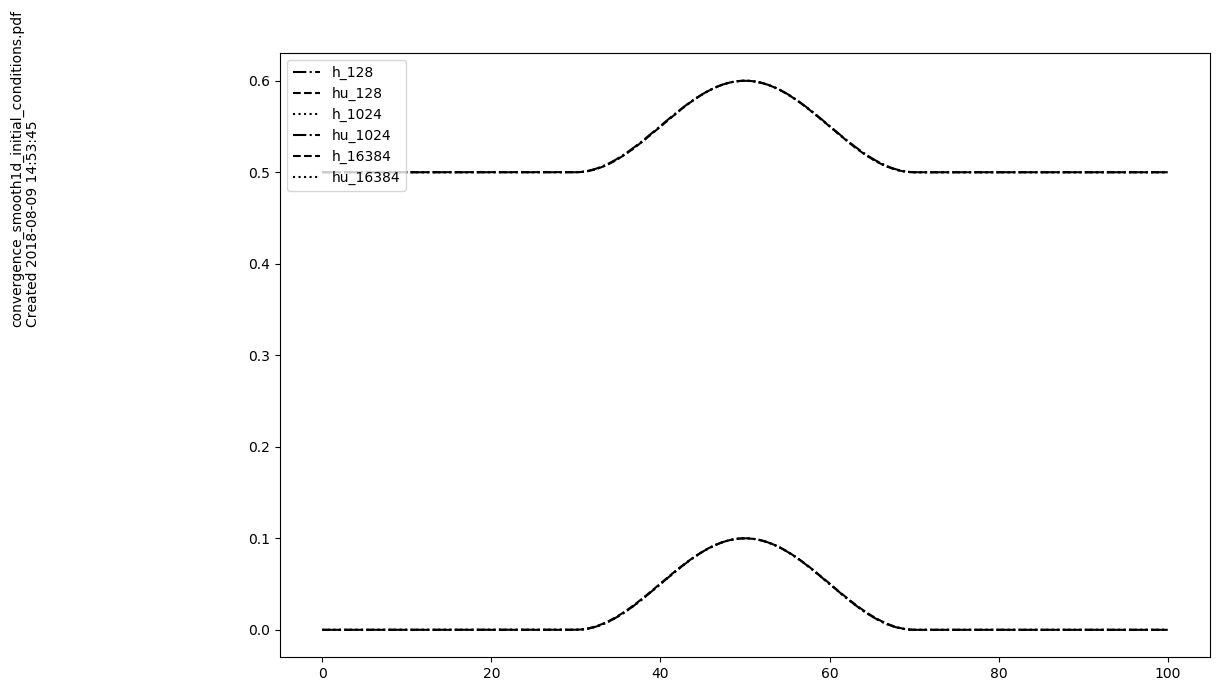

In [8]:
#Plot initial conditions            
fig = plt.figure()
setBwStyles(fig.gca())

for nx in [128, 1024, 16384]:
    h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, nx, 9.81, 1)
    x = np.linspace(0.0, nx*dx, nx)
    
    #plt.subplot(211)
    plt.plot(x, h0[1:-1, 1:-1].flatten(), marker=' ', label='h_' + str(nx))
    plt.plot(x, hu0[1:-1, 1:-1].flatten(), marker=' ', label='hu_' + str(nx))
    #plt.subplot(212)
    #setBwStyles(fig.gca())
    #plt.plot(x, hu0.T, marker=" ", label='hu_' + str(nx))
    #plt.legend(loc='upper left')
    
#plt.xlim([47, 53])
#plt.ylim([0.58, 0.61])
plt.legend(loc='upper left')
save_figure(fig, 'initial_conditions')

In [9]:
def gen_filename(simulator, nx):
    return "smooth1d_" + str(simulator.__name__) + "_" + str(nx) + ".npz"

In [10]:
def sanity_check(variable, variable_name):
    maxval = np.amax(variable)
    minval = np.amin(variable)
    if (np.isnan(maxval) or np.isnan(minval)):
        print("=== WARNING ===")
        print(variable_name + " contains NaN values")
        print("=== WARNING ===")

def run_benchmark(datafilename, simulator, courant_number, nx, reference_nx, 
                  ghost_cells, g=9.81, force_rerun=False, transpose=False):

    if (os.path.isfile(datafilename) and force_rerun == False):
        print("=== WARNING ===")
        print("Existing simulation exists, skipping simulation")
        print("=== WARNING ===")
    else:
        h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, reference_nx, g, ghost_cells)
        ny = ghost_cells
        dt = dt * courant_number

        #Initialize simulator
        with Common.Timer(simulator.__name__ + "_" + str(nx)) as timer:
            if (transpose):
                h0 = np.ascontiguousarray(np.transpose(h0))
                hu0, hv0 = np.ascontiguousarray(np.transpose(hv0)), np.ascontiguousarray(np.transpose(hu0))
                dx, dy = dy, dx
                nx, ny = ny, nx

            sim = simulator(cuda_context, 
                            h0, hu0, hv0, 
                            nx, ny, 
                            dx, dy, dt, 
                            g)

            t, nt = sim.simulate(1.0)
            
            h, hu, hv = sim.download()
            
            if (transpose):
                h = np.transpose(h)
                hu, hv = np.ascontiguousarray(np.transpose(hv)), np.ascontiguousarray(np.transpose(hu))

            h  =  h[ghost_cells, ghost_cells:-ghost_cells]
            hu = hu[ghost_cells, ghost_cells:-ghost_cells]
            hv = hv[ghost_cells, ghost_cells:-ghost_cells]
            
            sanity_check(h, "h")
            sanity_check(hu, "hu")
            sanity_check(hv, "hv")

            np.savez_compressed(datafilename, h=h, hu=hu, hv=hv)
        
    gc.collect() # Force run garbage collection to free up memory
    
    return [timer.secs, nt, dt]

In [11]:
reference_nx = 16384
domain_sizes = [8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
#domain_sizes = [8, 16, 32, 64, 128, 256]

simulators = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
simulator_ghost_cells = [1, 1, 1, 2, 2, 2, 2]
simulator_reference = [LxF.LxF, FORCE.FORCE, HLL.HLL, HLL2.HLL2, KP07.KP07, KP07_dimsplit.KP07_dimsplit, WAF.WAF]
simulator_courant_numbers = [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
force_rerun=True
transpose=True

#reference_nx = 4096
#domain_sizes = [32, 64, 128, 256, 512, 1024]
#simulators = [HLL2.HLL2, WAF.WAF]
#simulator_ghost_cells = [2, 2]
#simulator_reference = [HLL2.HLL2, WAF.WAF]
#simulator_courant_numbers = [0.95, 0.95]
#force_rerun=True

sim_elapsed_time = np.zeros((len(simulators), len(domain_sizes)))
sim_dt = np.zeros((len(simulators), len(domain_sizes)))
sim_nt = np.zeros((len(simulators), len(domain_sizes)))

#Warmup to compile kernels
with Common.Timer("warmup", verbose=False) as timer:
    for i in range(len(simulators)):
        run_benchmark("warmup", 
                      simulators[i], 
                      simulator_courant_numbers[i], 
                      16, 16, 
                      simulator_ghost_cells[i], 
                      force_rerun=force_rerun,
                      transpose=transpose)
print("Completed warmup in {:} s".format(timer.secs))
    
with Common.Timer("simulation", verbose=False) as timer:
    for i in range(len(simulators)):        
        # Run the simulation for all the domain sizes
        for j, nx in enumerate(domain_sizes):
            datafilename = gen_filename(simulators[i], nx)
            [secs, nt, dt] = run_benchmark(datafilename, 
                          simulators[i], 
                          simulator_courant_numbers[i], 
                          nx, reference_nx, 
                          simulator_ghost_cells[i], 
                          force_rerun=force_rerun,
                          transpose=transpose)
            sim_elapsed_time[i, j] = secs
            sim_dt[i, j] = dt
            sim_nt[i, j] = nt

        # Run reference with a low CFL-number
        datafilename = gen_filename(simulators[i], reference_nx)
        run_benchmark(datafilename, 
                      simulators[i], 
                      simulator_courant_numbers[i] * 0.5, 
                      reference_nx, reference_nx, 
                      simulator_ghost_cells[i], 
                      force_rerun=force_rerun,
                      transpose=transpose)
print("Completed simulation in {:} s".format(timer.secs))

=> LxF_16 6523.453712 ms
=> FORCE_16 5007.396936 ms
=> HLL_16 4800.127506 ms
=> HLL2_16 5638.219595 ms
=> KP07_16 7086.654186 ms
=> KP07_dimsplit_16 7141.783237 ms
=> WAF_16 5859.811068 ms
Completed warmup in 44.02079224586487 s
=> LxF_8 13.991833 ms
=> LxF_16 14.010429 ms
=> LxF_32 14.026165 ms
=> LxF_64 11.982918 ms
=> LxF_128 18.986464 ms
=> LxF_256 19.020557 ms
=> LxF_512 28.024435 ms
=> LxF_1024 32.024145 ms
=> LxF_2048 41.027546 ms
=> LxF_4096 85.061312 ms
=> LxF_16384 1690.952063 ms
=> FORCE_8 23.024321 ms
=> FORCE_16 27.024746 ms
=> FORCE_32 26.012421 ms
=> FORCE_64 25.011539 ms
=> FORCE_128 25.009394 ms
=> FORCE_256 24.009466 ms
=> FORCE_512 31.022310 ms
=> FORCE_1024 29.993534 ms
=> FORCE_2048 49.028873 ms
=> FORCE_4096 108.098269 ms
=> FORCE_16384 2345.041752 ms
=> HLL_8 21.987915 ms
=> HLL_16 20.993948 ms
=> HLL_32 17.985582 ms
=> HLL_64 15.984535 ms
=> HLL_128 20.986795 ms
=> HLL_256 27.027845 ms
=> HLL_512 34.017563 ms
=> HLL_1024 39.020777 ms
=> HLL_2048 56.039333 ms
=> 

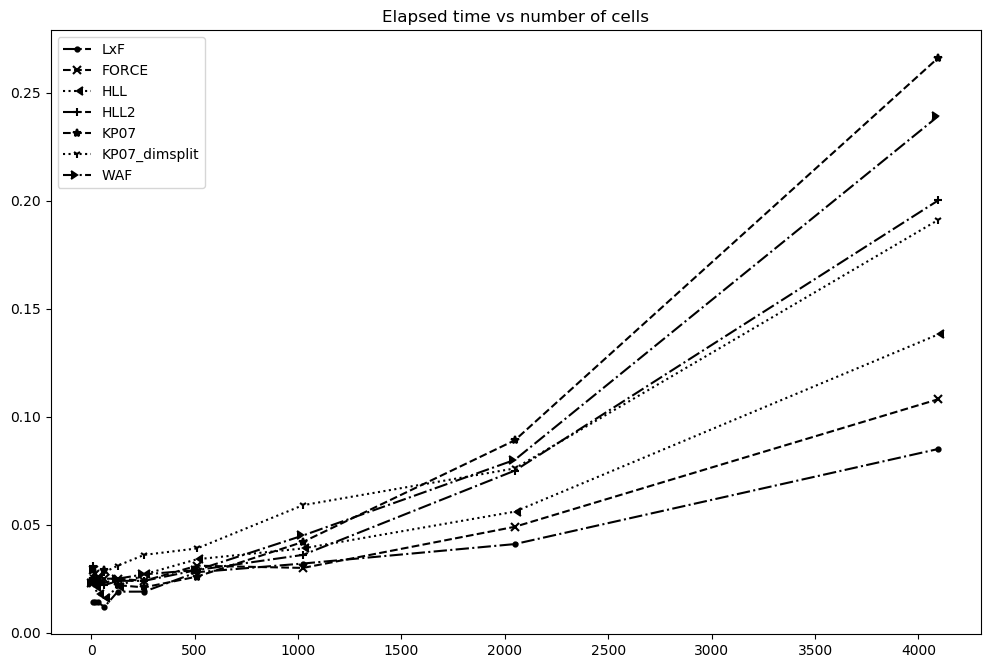

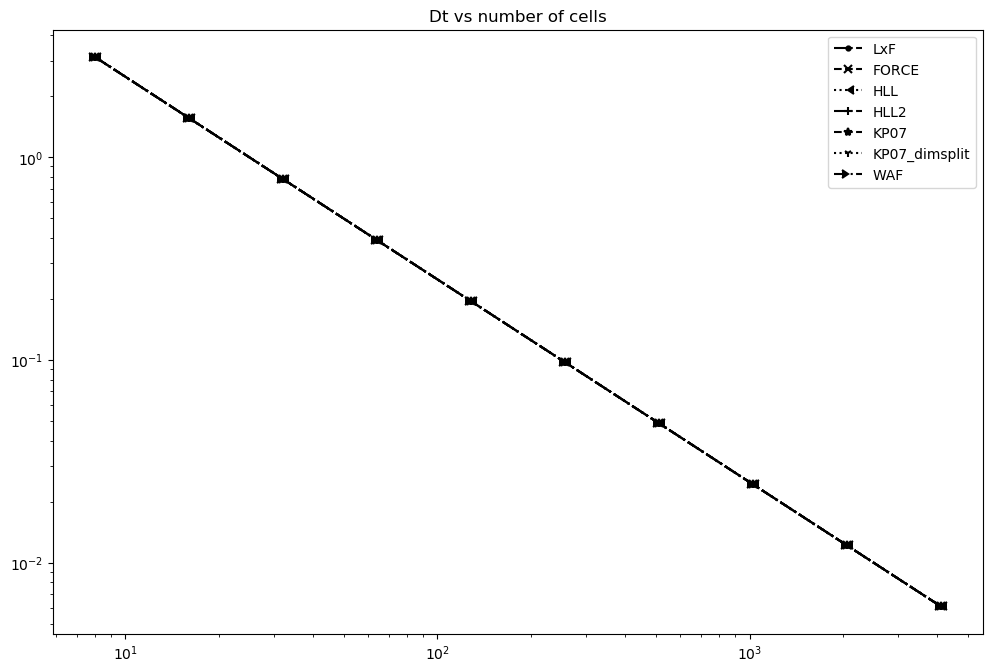

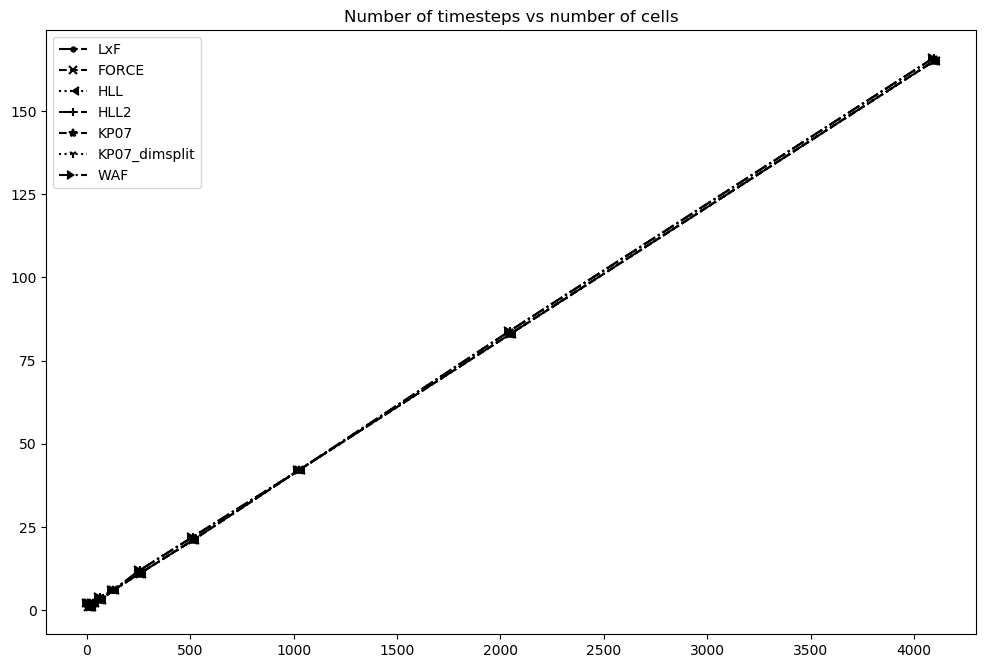

In [12]:
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Elapsed time vs number of cells")
for i, simulator in enumerate(simulators):
    plt.plot(domain_sizes, sim_elapsed_time[i,:], label=simulator.__name__)
plt.legend()
    
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Dt vs number of cells")
for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, sim_dt[i,:], label=simulator.__name__)
plt.legend()
    
fig = plt.figure()
setBwStyles(fig.gca())
plt.title("Number of timesteps vs number of cells")
for i, simulator in enumerate(simulators):
    plt.plot(domain_sizes, sim_nt[i,:], label=simulator.__name__)
plt.legend()

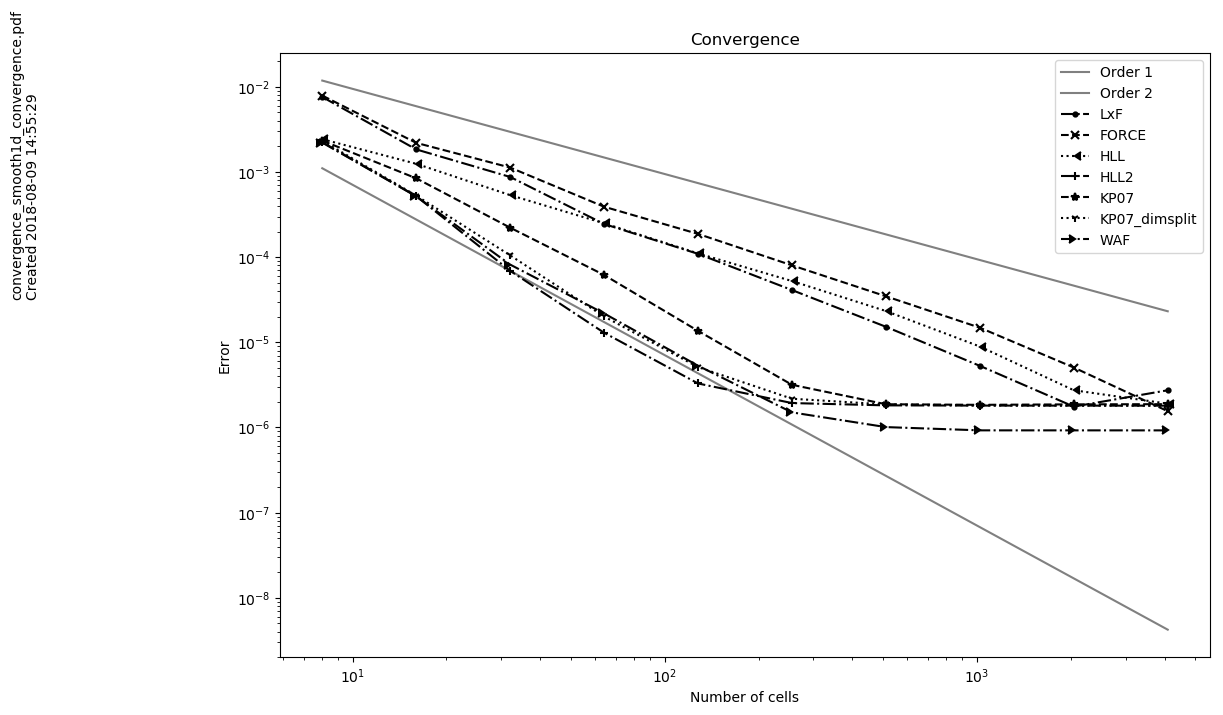

In [13]:
conservation = np.zeros((len(simulators), len(domain_sizes)))
error = np.zeros((len(simulators), len(domain_sizes)))
order = np.zeros((len(simulators), len(domain_sizes)-1))

for i, simulator in enumerate(simulators):
    #Read the reference solution
    datafilename = gen_filename(simulator, reference_nx)
    with np.load(datafilename) as data:
        h_ref = data['h']
    
    #Compute conservation and error for subsequent resolutions
    for j, nx in enumerate(domain_sizes):
        #Read current resolution
        datafilename = gen_filename(simulator, nx)
        with np.load(datafilename) as data:
            h = data['h']
        
        #Downsample reference to current resolution
        h_ref_downsampled = downsample(h_ref, reference_nx/nx)
        
        #Compute error per cell
        error[i, j] = np.linalg.norm((h_ref_downsampled - h).flatten(), ord=1) / nx
        conservation[i, j] = (np.sum(h_ref) - np.sum(h))
    
    #Compute the numerical order
    a = np.arange(1, len(domain_sizes))
    order[i,:] = np.log2(error[i, :-1] / error[i, 1:])
    
fig = plt.figure()
setBwStyles(fig.gca())

x = np.linspace(domain_sizes[0], domain_sizes[-1], 100);

scaling = np.max(error[:,0]) * domain_sizes[0] * 1.5
plt.loglog(x, scaling/x, '-', color='gray', label='Order 1')

scaling = np.min(error[:,0]) * domain_sizes[0]**2 * 0.5
plt.loglog(x, scaling/(x*x), '-', color='gray', label='Order 2')

for i, simulator in enumerate(simulators):
    plt.loglog(domain_sizes, error[i,:], label=simulators[i].__name__)
    
plt.xlabel('Number of cells')
plt.ylabel('Error')
plt.title("Convergence")
plt.legend()
save_figure(fig, 'convergence')

In [14]:
import pandas as pd
from IPython.display import display

table = pd.DataFrame(order, columns=domain_sizes[:-1], index=[simulator.__name__ for simulator in simulators])
display(table)

order_summary = pd.DataFrame(np.empty((len(simulators), 3)), columns=['Max', 'Min', 'Mean'], index=[simulator.__name__ for simulator in simulators])
for i, simulator in enumerate(simulators):
    order_summary.loc[simulator.__name__] = [np.max(order[i,:]), 
        np.min(order[i,:]), 
        np.mean(order[i,:])]
display(order_summary)


,8,16,32,64,128,256,512,1024,2048
LxF,2.046098,1.074325,1.834294,1.165476,1.412700,1.432408,1.524218,1.589650,-0.637310
FORCE,1.843813,0.964270,1.528037,1.060302,1.226554,1.206903,1.225360,1.553093,1.704214
HLL,0.959785,1.222461,1.098614,1.175015,1.078323,1.169317,1.385120,1.705706,0.523056
HLL2,2.108427,2.911967,2.415012,1.978696,0.764850,0.089884,0.008152,0.001766,0.001885
KP07,1.469665,1.925327,1.846630,2.180099,2.103188,0.758878,0.022805,-0.018655,-0.007395
KP07_dimsplit,2.133675,2.333060,2.385194,1.974368,1.233662,0.222392,0.038976,0.006282,0.002569
WAF,2.095899,2.662203,1.905463,2.039412,1.820916,0.573782,0.126937,0.000318,0.000613


,Max,Min,Mean
LxF,2.046098,-0.637310,1.271318
FORCE,1.843813,0.964270,1.368061
HLL,1.705706,0.523056,1.146377
HLL2,2.911967,0.001766,1.142293
KP07,2.180099,-0.018655,1.142283
KP07_dimsplit,2.385194,0.002569,1.147798
WAF,2.662203,0.000318,1.247282


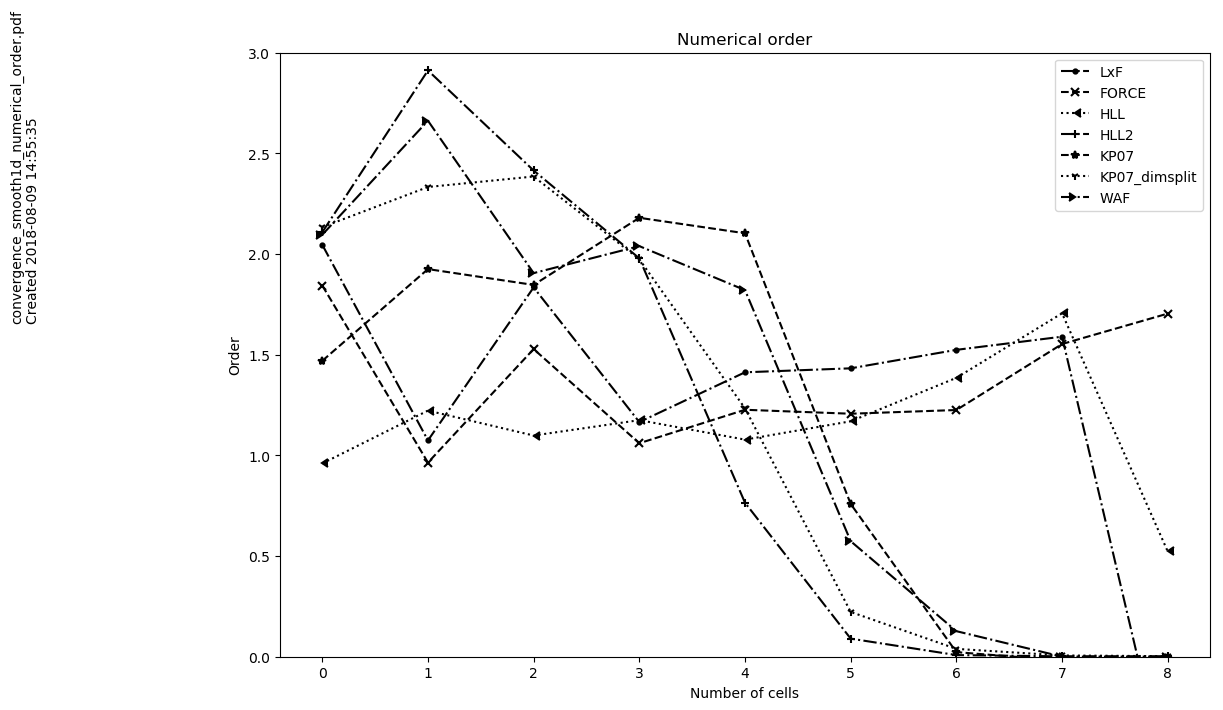

In [15]:
fig = plt.figure()
setBwStyles(fig.gca())

for i, simulator in enumerate(simulators):
    plt.plot(order[i,:], label=simulator.__name__)
    
plt.ylim([0, 3])
plt.xlabel('Number of cells')
plt.ylabel('Order')
plt.legend()
plt.title("Numerical order")
save_figure(fig, 'numerical_order')

In [16]:
def plot_solution(simulator, nx, label, **kwargs):
    datafilename = gen_filename(simulator, nx)
    
    #Read the solution
    with np.load(datafilename) as data:
        h = data['h']
        
    x = np.linspace(0.5, nx-0.5, nx)*100.0/float(nx)
    
    plt.plot(x, h, label=label, **kwargs)
    
    h = None
    x = None
    gc.collect() # Force run garbage collection to free up memory
    
def plot_comparison(nx, **kwargs):
    plot_solution(HLL2.HLL2, reference_nx, 'Reference', marker=' ', linestyle='-')

    for i, simulator in enumerate(simulators):
        plot_solution(simulator, nx, simulator.__name__, **kwargs)

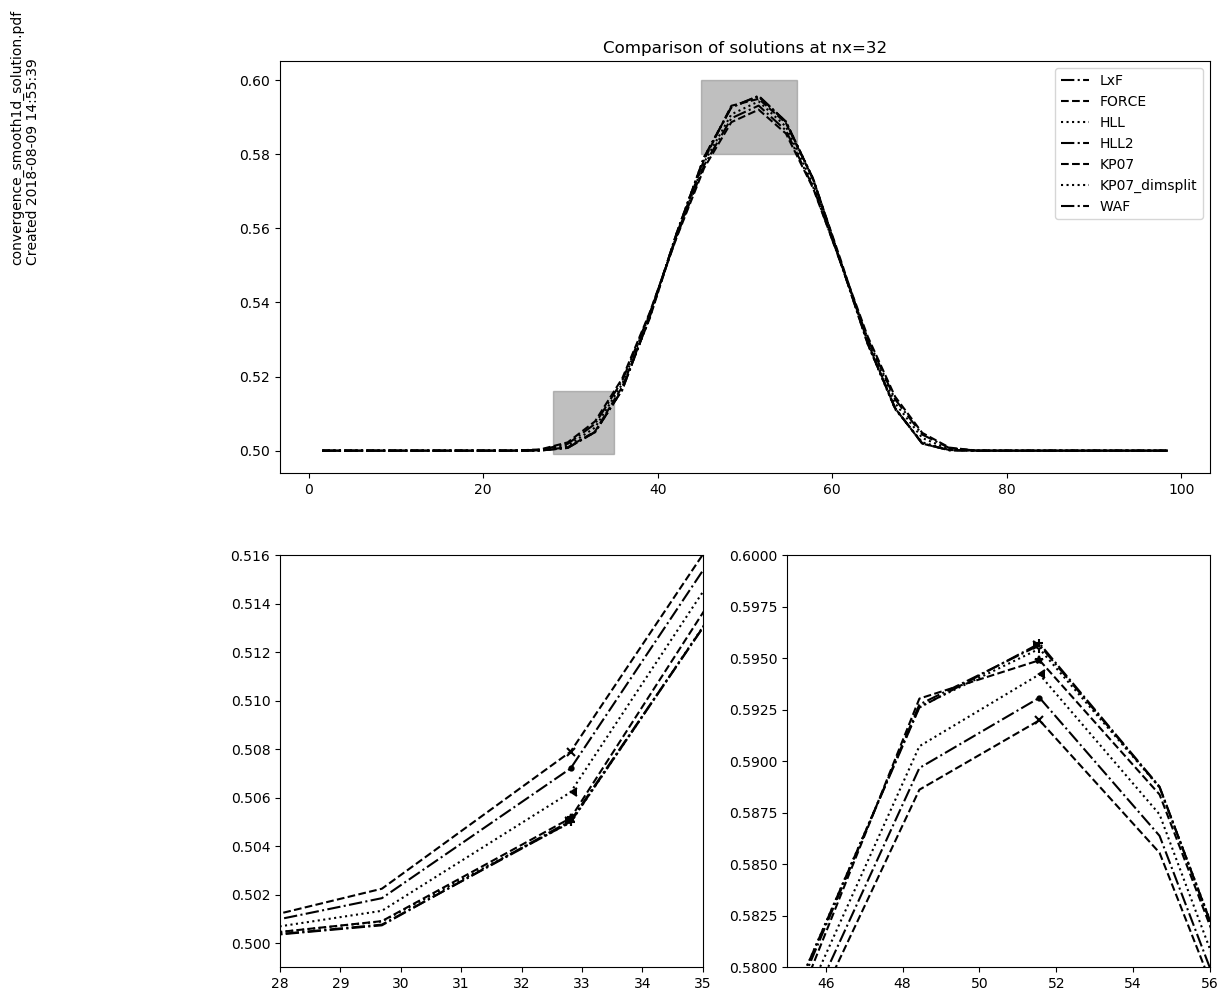

In [17]:
boxes = np.array([\
         [[28, 35], [0.499, 0.516]], \
         [[45, 56], [0.58, 0.60]]
         ])
comparison_nx = 32

fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
    
ax1 = fig.add_subplot(gs[0,:])
setBwStyles(ax1)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.title("Comparison of solutions at nx=" + str(comparison_nx))
plt.legend()

ax2 = fig.add_subplot(gs[1,0])
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, markevery=2)
plt.xlim(boxes[0, 0])
plt.ylim(boxes[0, 1])

ax3 = fig.add_subplot(gs[1,1])
setBwStyles(ax3)
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, comparison_nx, simulator.__name__, markevery=2)
plt.xlim(boxes[1, 0])
plt.ylim(boxes[1, 1])
    
save_figure(fig, 'solution')

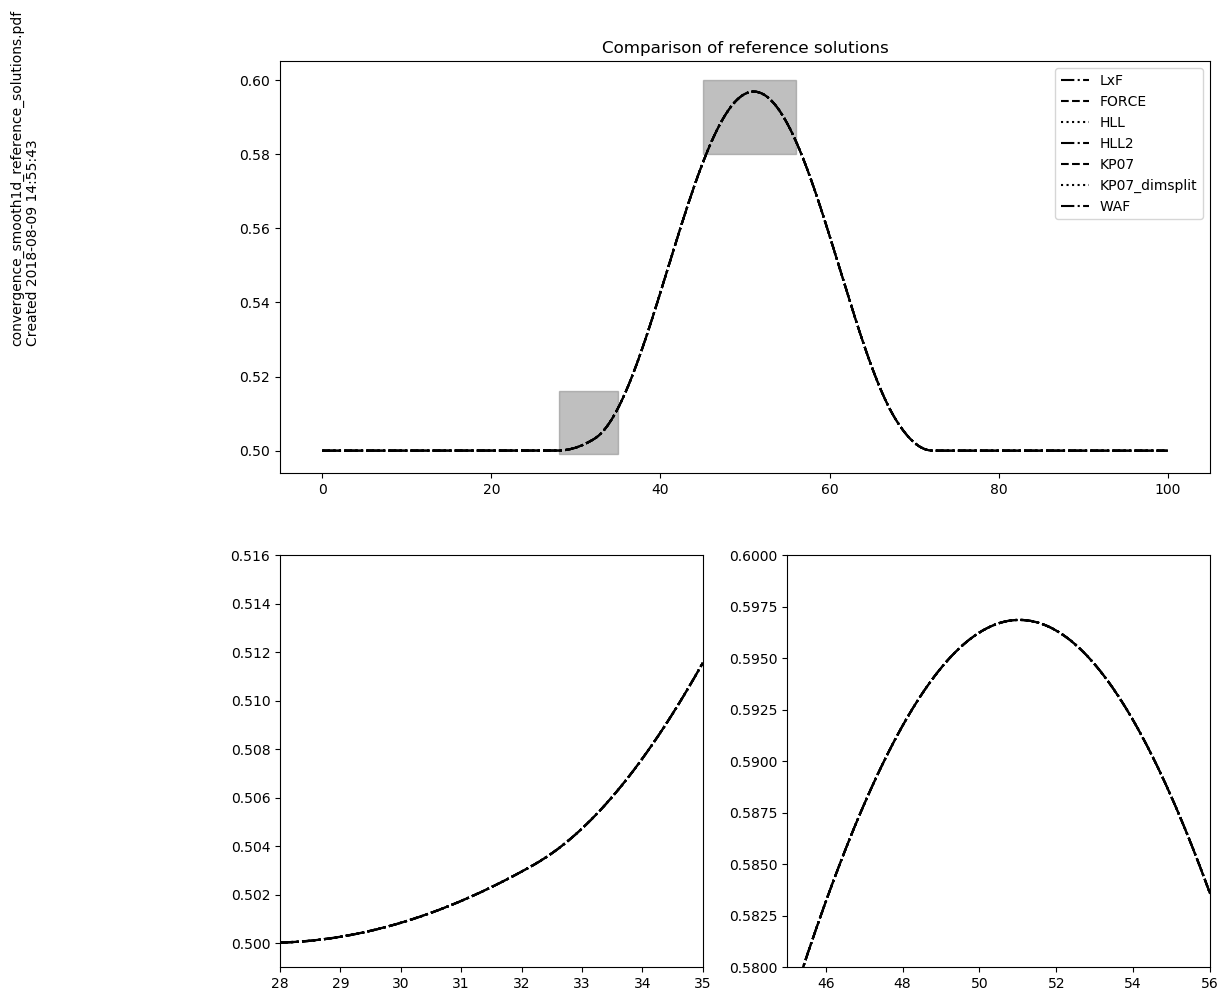

In [18]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2)
    
ax1 = fig.add_subplot(gs[0,:])
setBwStyles(ax1)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
for box_x, box_y in boxes:
    x = np.kron(box_x, np.ones((2)))
    y = np.hstack((box_y, box_y[::-1]))
    fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
plt.title("Comparison of reference solutions")
plt.legend()

ax2 = fig.add_subplot(gs[1,0])
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
plt.xlim(boxes[0, 0])
plt.ylim(boxes[0, 1])

ax3 = fig.add_subplot(gs[1,1])
setBwStyles(ax3)
setBwStyles(ax2)
for simulator in simulators:
    plot_solution(simulator, reference_nx, simulator.__name__, marker=' ')
plt.xlim(boxes[1, 0])
plt.ylim(boxes[1, 1])
    
save_figure(fig, 'reference_solutions')

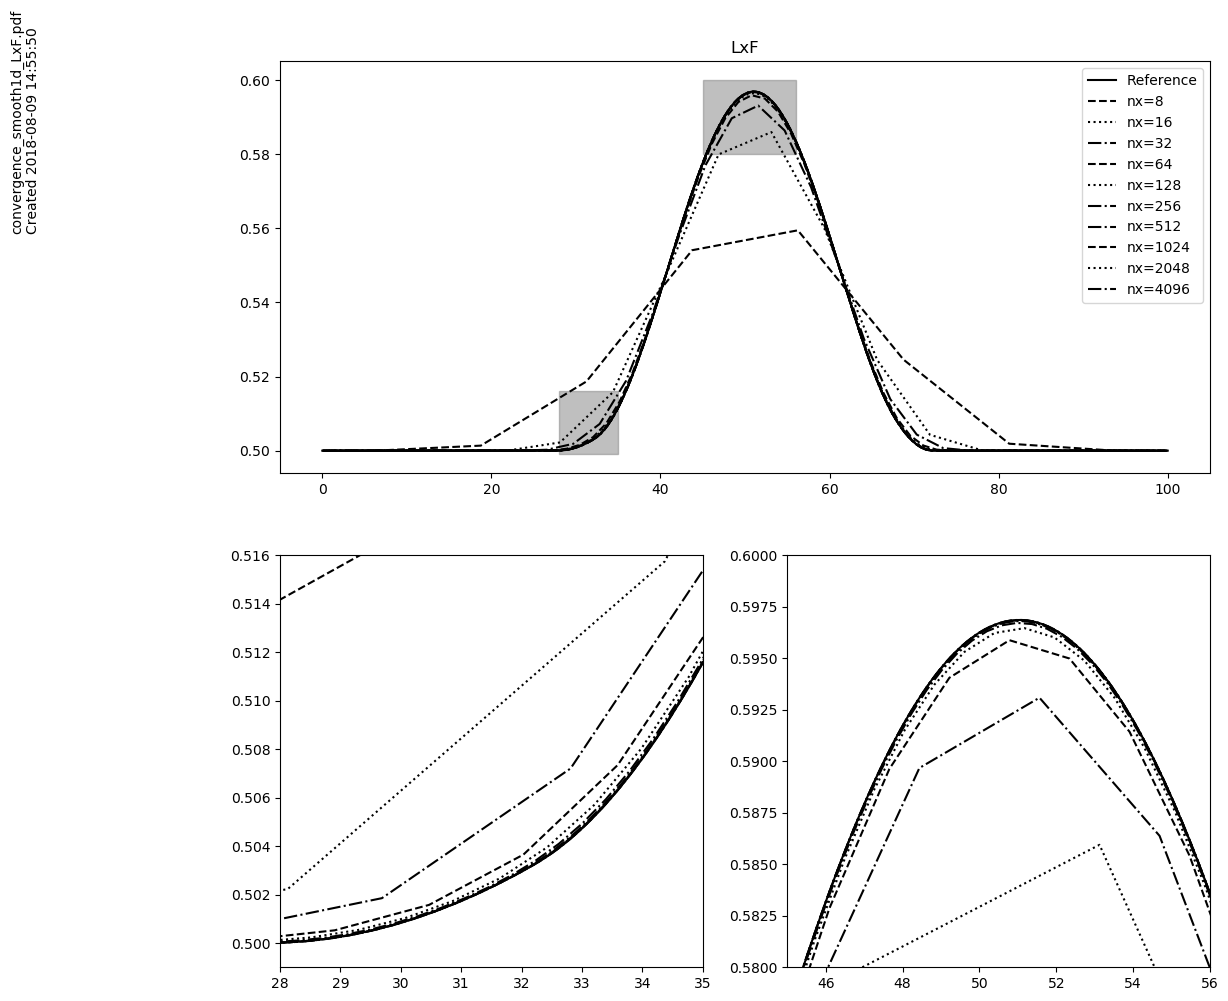

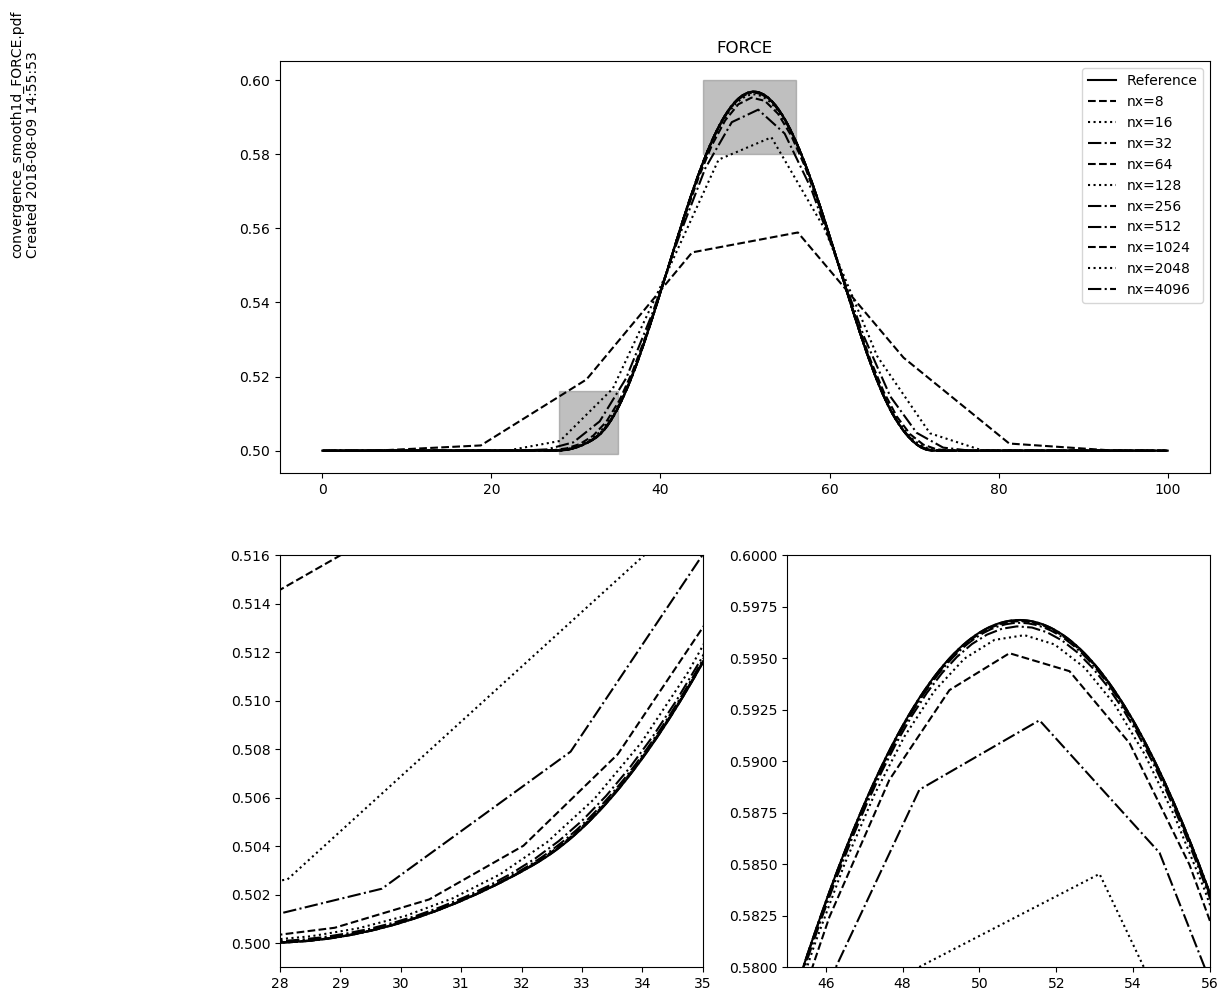

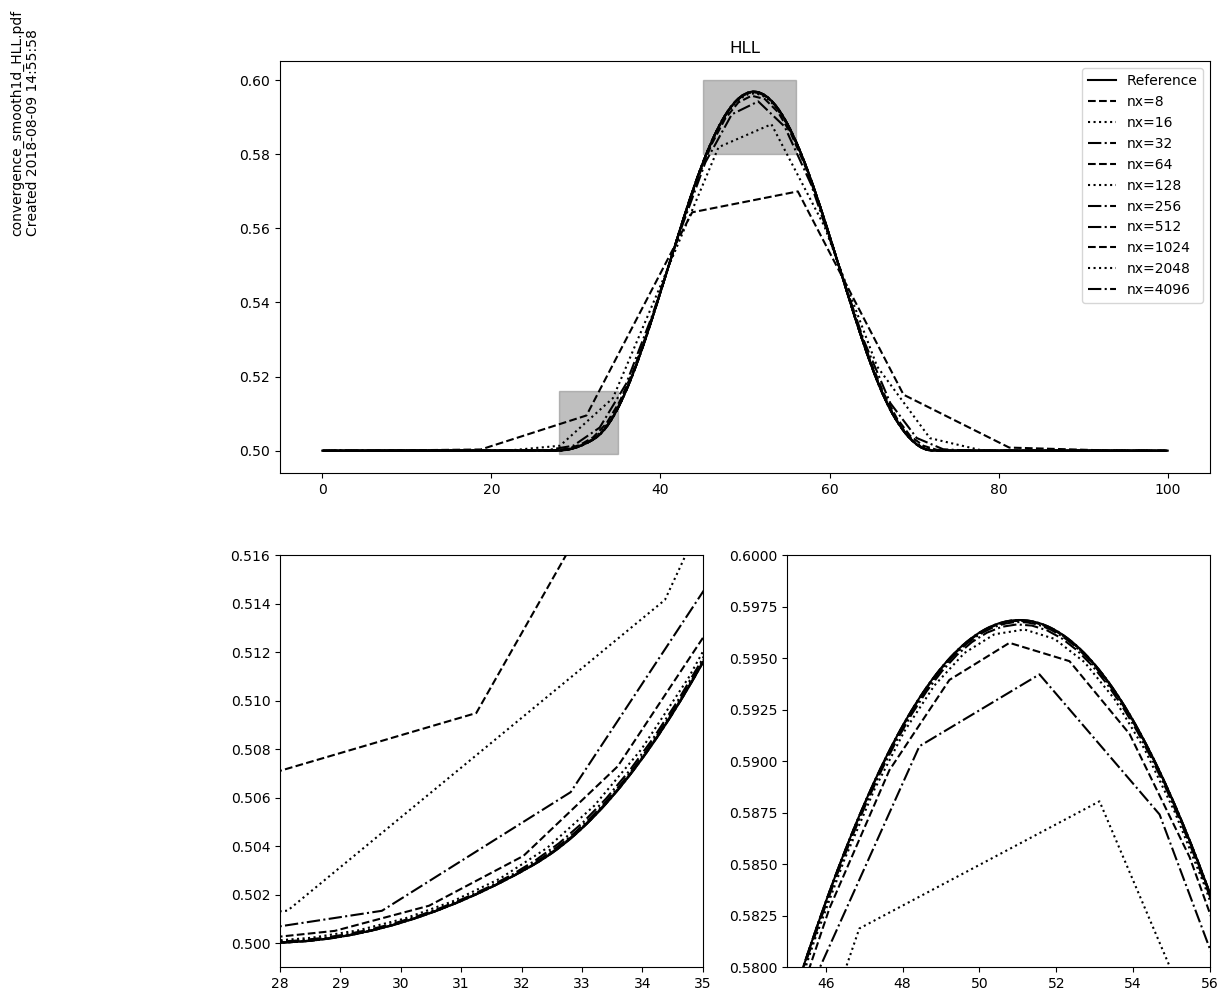

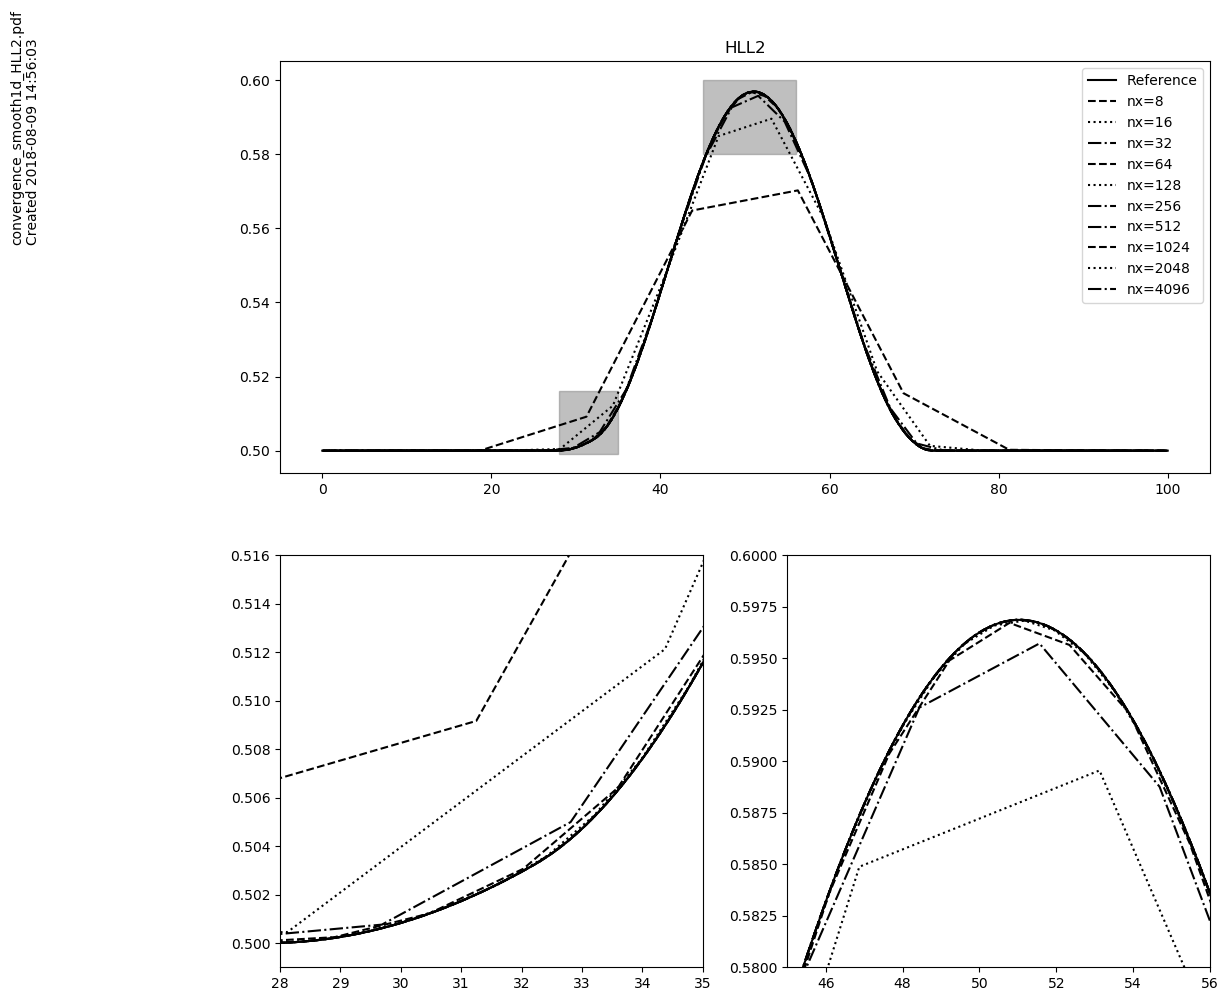

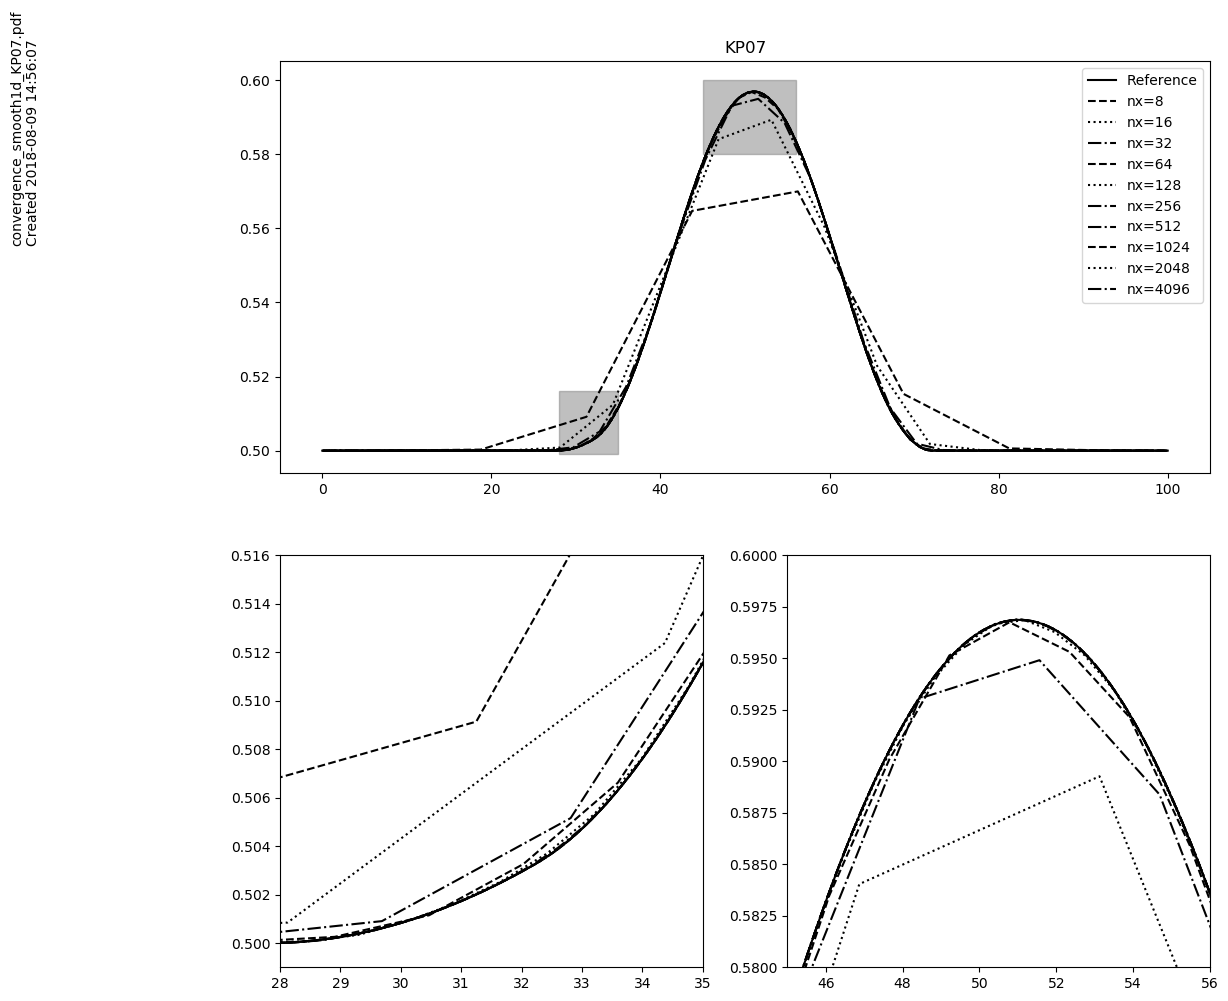

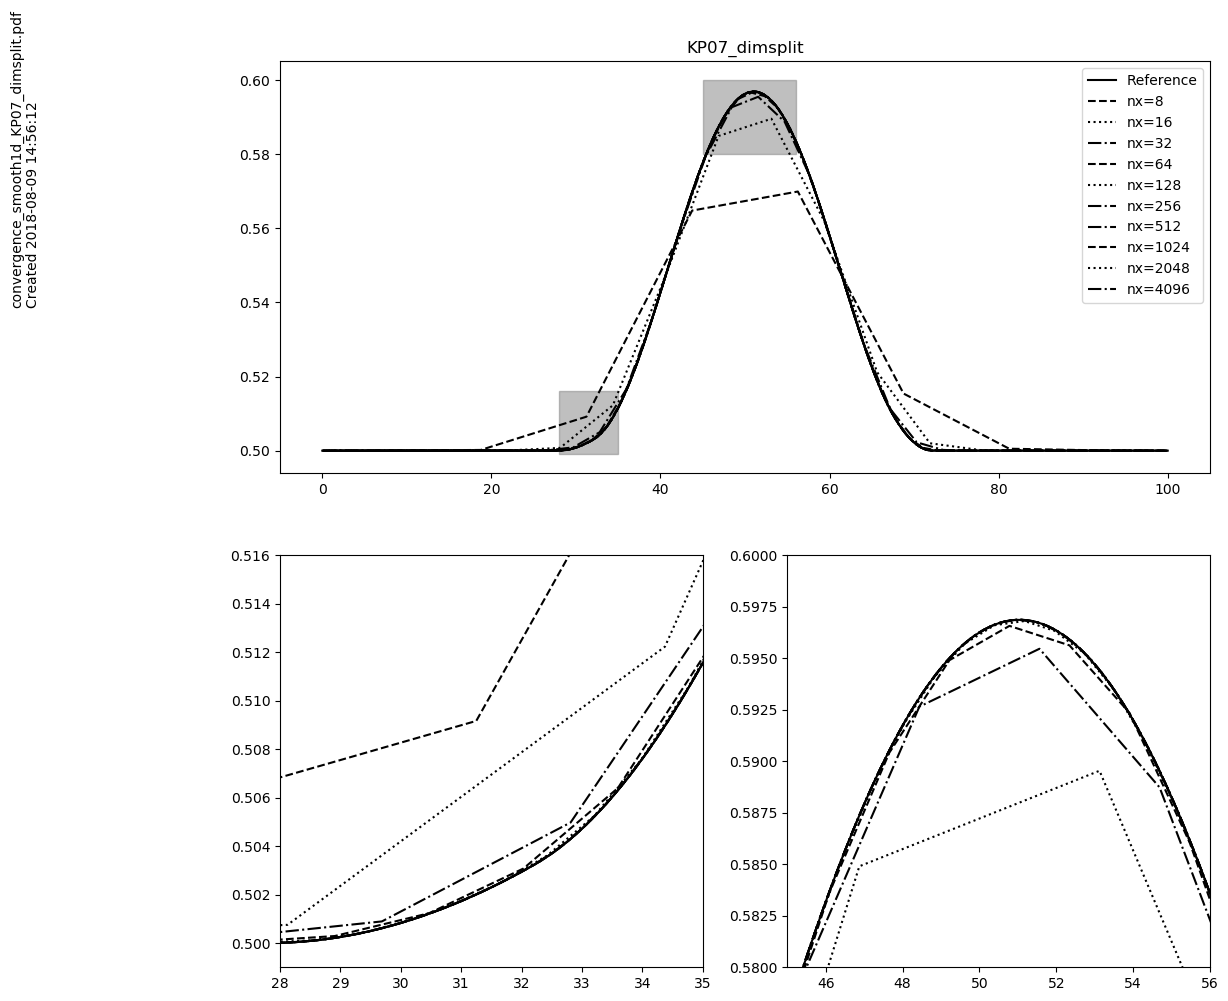

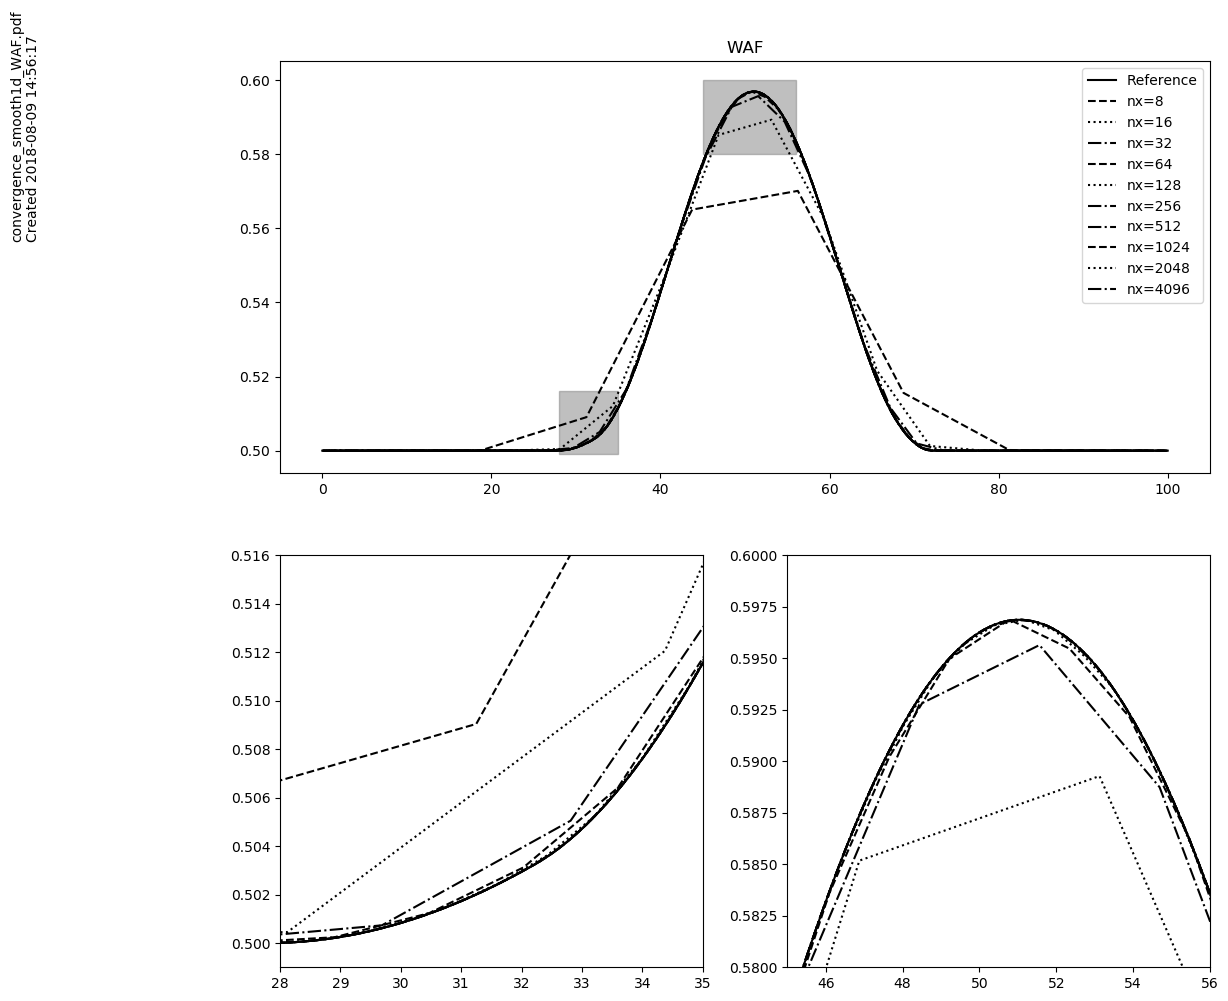

In [19]:
for simulator in simulators:
    fig = plt.figure(figsize=(12, 12))
    
    gs = gridspec.GridSpec(2, 2)
    
    ax1 = fig.add_subplot(gs[0,:])
    setBwStyles(ax1)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')
    for box_x, box_y in boxes:
        x = np.kron(box_x, np.ones((2)))
        y = np.hstack((box_y, box_y[::-1]))
        fig.gca().fill(x, y, fill=True, linestyle='-', color='gray', alpha=0.5)
    plt.title(str(simulator.__name__))
    plt.legend()
    
    ax2 = fig.add_subplot(gs[1,0])
    setBwStyles(ax2)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')  
    plt.xlim(boxes[0, 0])
    plt.ylim(boxes[0, 1])
    
    ax3 = fig.add_subplot(gs[1,1])
    setBwStyles(ax3)
    plot_solution(simulator, reference_nx, 'Reference', linestyle='-', marker=' ')
    for j, nx in enumerate(domain_sizes):
        plot_solution(simulator, nx, 'nx=' + str(nx), marker=' ')   
    plt.xlim(boxes[1, 0])
    plt.ylim(boxes[1, 1])
    
    save_figure(fig, simulator.__name__)